In [1]:
import numpy as np
import scipy.signal as sps
import sympy as sym 
import scipy.optimize as sopt
from scipy.integrate import ode
%matplotlib inline   
import matplotlib.pyplot as plt
from sympy.utilities.lambdify import lambdify

## Without control
$$ \frac{di_d}{dt}  = \frac{1}{L} \left(\eta_d \frac{v_{dc}}{2} - R i_d + L \omega i_q - v_{sd}\right) $$
$$ \frac{di_q}{dt}  = \frac{1}{L} \left(\eta_q \frac{v_{dc}}{2} - R i_q - L \omega i_d - v_{sq}\right) $$
$$ \frac{dv_{dc}}{dt} = \frac{1}{C} \left( i_{dc} -  \frac{3}{4} \left( \eta_d i_d + \eta_q i_q \right) \right) $$


In [2]:
eta_d,eta_q = sym.symbols('eta_d,eta_q')
i_d,i_q,v_dc,i_dc = sym.symbols('i_d,i_q,v_dc,i_dc')
i_d_ref,i_q_ref,v_dc_ref = sym.symbols('i_d_ref,i_q_ref,v_dc_ref')
v_sd,v_sq = sym.symbols('v_sd,v_sq')
v_gd,v_gq = sym.symbols('v_gd,v_gq')
L_g,R_g = sym.symbols('L_g,R_g')
L,R,C,omega = sym.symbols('L,R,C,omega')
u_d,u_q = sym.symbols('u_d,u_q')
p_ext,i_ext = sym.symbols('p_ext,i_ext')
K_p,T_pi,K_p_v,T_pi_v = sym.symbols('K_p,T_pi,K_p_v,T_pi_v') 
p_ref,q_ref = sym.symbols('p_ref,q_ref')
xi_d,xi_q,xi_v_dc = sym.symbols('xi_d,xi_q,xi_v_dc')


In [3]:


v_sd = v_gd + R_g*i_d - L_g*omega*i_q 
v_sq = v_gq + R_g*i_q + L_g*omega*i_d 

error_v_dc = v_dc_ref**2 - v_dc**2

p_ref = - K_p_v * (error_v_dc + xi_v_dc/T_pi_v)

i_q_ref = 2.0/3.0*(p_ref*v_sq + q_ref*v_sd)/(v_sd**2 + v_sq**2)
i_d_ref = 2.0/3.0*(p_ref*v_sd - q_ref*v_sq)/(v_sd**2 + v_sq**2)

error_d = i_d_ref - i_d
error_q = i_q_ref - i_q

u_d = K_p * (error_d + xi_d/T_pi)
u_q = K_p * (error_q + xi_q/T_pi)

i_ext = p_ext/v_dc

eta_d = 2.0/v_dc * (u_d - L*omega*i_q + v_sd)
eta_q = 2.0/v_dc * (u_q + L*omega*i_d - v_sq)


di_d  = 1/L*(eta_d*v_dc/2 - R*i_d + L*omega*i_q - v_sd)
di_q  = 1/L*(eta_q*v_dc/2 - R*i_q - L*omega*i_d - v_sq)
dv_dc = 1/C*(i_ext - 3/4*(eta_d*i_d + eta_q*i_q ))
dxi_d  = error_d
dxi_q  = error_q
dxi_vdc  = error_v_dc

f = sym.Matrix([[di_d],[di_q],[dv_dc],[dxi_d],[dxi_q],[dxi_vdc]])
x = sym.Matrix([[i_d],[i_q],[v_dc],[xi_d],[xi_q],[xi_v_dc]])
u = sym.Matrix([[v_sd],[v_sq],[p_ext],[v_dc_ref],[q_ref]])

F_x = f.jacobian(x)



In [4]:
# test para ver si las cosas van bien
from sympy.utilities.lambdify import lambdify
func = lambdify(x, f,'numpy') # returns a numpy-ready function
print(func(1,2,3,5,6,7))

[[ (K_p*((-0.666666666666667*K_p_v*(v_dc_ref**2 - 9 + 7/T_pi_v)*(-2*L_g*omega + R_g + v_gd) - 0.666666666666667*q_ref*(L_g*omega + 2*R_g + v_gq))/((-2*L_g*omega + R_g + v_gd)**2 + (L_g*omega + 2*R_g + v_gq)**2) - 1 + 5/T_pi) - R)/L]
 [ (K_p*((-0.666666666666667*K_p_v*(v_dc_ref**2 - 9 + 7/T_pi_v)*(L_g*omega + 2*R_g + v_gq) + 0.666666666666667*q_ref*(-2*L_g*omega + R_g + v_gd))/((-2*L_g*omega + R_g + v_gd)**2 + (L_g*omega + 2*R_g + v_gq)**2) - 2 + 6/T_pi) - 2.0*L_g*omega - 2*R - 4.0*R_g - 2.0*v_gq)/L]
 [ (-0.5*K_p*((-0.666666666666667*K_p_v*(v_dc_ref**2 - 9 + 7/T_pi_v)*(-2*L_g*omega + R_g + v_gd) - 0.666666666666667*q_ref*(L_g*omega + 2*R_g + v_gq))/((-2*L_g*omega + R_g + v_gd)**2 + (L_g*omega + 2*R_g + v_gq)**2) - 1 + 5/T_pi) - K_p*((-0.666666666666667*K_p_v*(v_dc_ref**2 - 9 + 7/T_pi_v)*(L_g*omega + 2*R_g + v_gq) + 0.666666666666667*q_ref*(-2*L_g*omega + R_g + v_gd))/((-2*L_g*omega + R_g + v_gd)**2 + (L_g*omega + 2*R_g + v_gq)**2) - 2 + 6/T_pi) + 2.0*L_g*omega + 1.5*R_g + p_ext/3 - 0.5*

## Steady state

In [15]:
C_value = 2000.0e-6;
S_cc = 10e6;
U_b = 400;
XR = 0.5;
R_value = 0.05;
L_value = 1.0e-3;
T_d_idq = 0.002;
T_d_vdc = 0.01;

Z_cc = U_b**2/S_cc

# Z**2 = R**2 + X**2
# Z**2 = R**2*XR**2 + R**2 = R**2*(XR**2+1)
R_g_val = (Z_cc**2/(XR**2+1))**0.5
X = XR*R_g_val
omega_val = 2*np.pi*50

L_g_val =  X/omega


params = {'L':L_value,
          'R':R_value,
          'L_g':L_g_val,
          'R_g':R_g_val,
          'C':C_value,
          'omega':2.0*np.pi*50,
          'K_p_v':C_value/T_d_vdc,
          'T_pi_v':0.1,
          'v_gq':-np.sqrt(2./3)*400.0,
          'v_gd':0.0,
          'v_dc_ref':800,
          'q_ref':10.0e3,
          'p_ext':-150e3,
          'K_p':L_value/T_d_idq,
          'T_pi':L_value/R_value
         }

# sym.pretty_print(f.subs(params))

u = sym.Matrix([[i_d, i_q,v_dc,xi_d,xi_q,xi_v_dc ]])

f_ss = lambdify(u, f.subs(params),'numpy') # returns a numpy-ready function

def eqs_ss(x):
    
    i_d = x[0]
    i_q = x[1]
    v_dc = x[2]
    xi_d = x[3]
    xi_q = x[4]
    xi_v_dc = x[5]
        
    return f_ss(i_d, i_q,v_dc,xi_d,xi_q,xi_v_dc )

i_d_0 = 2.0/3.0*(-params['q_ref']/params['v_gq'])
i_q_0 = 2.0/3.0*( params['p_ext']/params['v_gq'])


x_0 = [i_d_0,i_q_0,800,0,0,0] 
sol = sopt.broyden2(eqs_ss, x_0, f_tol=1e-8)

print('i_d = {:2.3f}, i_q = {:2.3f}'.format(sol[0],sol[1]))
#print('[{:2.6f}, {:2.6f}]'.format(sol[0],sol[1]))

p = 3/2*(v_sd*i_d + v_sq*i_q)
q = 3/2*(v_sd*i_q - v_sq*i_d) 

h = sym.Matrix([[p],[q]])

params_ss = params

params_ss.update({'i_d':sol[0],
                  'i_q':sol[1],
                  'v_dc':sol[2],
                  'xi_d':sol[3],
                  'xi_q':sol[4],
                  'xi_v_dc':sol[5]                         
                 })

sym.N(h.subs(params_ss))
print('P_ext = {:2.1f} W'.format(p_ext.subs(params_ss)))
print('P = {:2.1f} W'.format(p.subs(params_ss)))
print('Q = {:2.1f} var'.format(q.subs(params_ss)))
print('v_sd = {:2.1f} V'.format(v_sd.subs(params_ss)))
print('v_sq = {:2.1f} V'.format(v_sq.subs(params_ss)))

i_d = 22.772, i_q = 327.395
P_ext = -150000.0 W
P = -158077.9 W
Q = 10000.0 var
v_sd = -2.0 V
v_sq = -321.8 V


In [16]:
f.subs(params)

Matrix([
[   -2.271008270327e-9],
[ -1.33877620100975e-9],
[-4.80213202536106e-10],
[-1.04866781924784e-10],
[-5.75255398871377e-11],
[ 5.82076609134674e-10]])

## Small Signal


In [17]:
F_x = f.jacobian(x)
f_A = lambdify([], F_x.subs(params_ss),'numpy')
#F_u = f.jacobian(u)
#f_B = lambdify([], F_u.subs(params),'numpy')
#H_x = h.jacobian(x)
#f_C = lambdify([], H_x.subs(params),'numpy')
#H_u = h.jacobian(u)
#f_D = lambdify([], H_u.subs(params),'numpy')

A = f_A()
#B = f_B()
#C = f_C()
#D = f_D()
eig, evec = np.linalg.eig(A)

print(eig)

[-506.81740935  +0.j         -203.97783005+198.73699154j
 -203.97783005-198.73699154j  -51.45857831  +0.j          -50.00000000  +0.j
  -10.59541817  +0.j        ]


## Simulation

/home/jmmauricio/bin/anaconda3/lib/python3.5/site-packages/scipy/integrate/_ode.py:1035: UserWarning: dopri5: step size becomes too small
  self.messages.get(idid, 'Unexpected idid=%s' % idid))


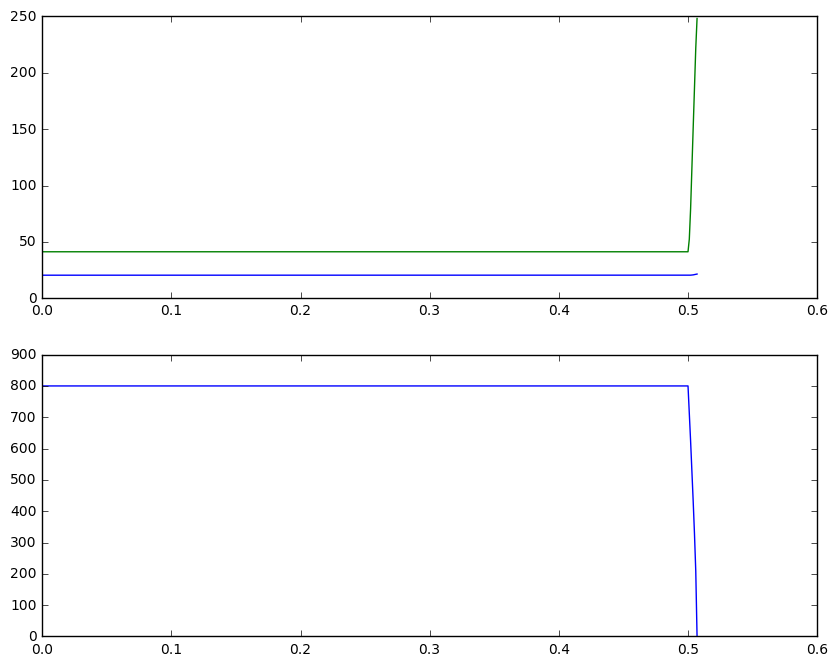

In [14]:
params_sim = {'L':L_value,
          'R':R_value,
          'L_g':L_g_val,
          'R_g':R_g_val,
          'C':C_value,
          'omega':2.0*np.pi*50,
          'K_p_v':800.0*C_value/T_d_vdc/800,
          'T_pi_v':0.1,
          'v_gq':-np.sqrt(2./3)*400.0,
          'v_gd':0.0,
          'v_dc_ref':800,
          'q_ref':10.0e3,
          'K_p':L_value/T_d_idq,
          'T_pi':L_value/R_value
         }

# sym.pretty_print(f.subs(params))

u = sym.Matrix([[i_d, i_q,v_dc,xi_d,xi_q,xi_v_dc,p_ext ]])

f_sim = lambdify(u, f.subs(params_sim),'numpy') # returns a numpy-ready function

def fun(t,x,params):
    
    i_d = x[0]
    i_q = x[1]
    v_dc = x[2]
    xi_d = x[3]
    xi_q = x[4]
    xi_v_dc = x[5]
        
    return f_sim(i_d, i_q,v_dc,xi_d,xi_q,xi_v_dc,params)
    

r = ode(fun).set_integrator('dopri5')
r.set_initial_value(sol,0.0).set_f_params(-20e3)
t1 = 1.0
dt = 0.001

T = [0.0]
X = [sol]

while r.successful() and r.t < t1:
    if r.t>0.5:
        r.set_f_params(-150e3)

    T += [r.t+dt]
    X += [r.integrate(r.t+dt)]

    
T = np.array(T)
X = np.array(X)

fig = plt.figure(figsize=(10,8))

ax1    = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)

ax1.plot(T,X[:,0])
ax1.plot(T,X[:,1])
ax2.plot(T,X[:,2])

plt.show()    



In [113]:
S_cc = 10e6
U_b = 400
Z_cc = U_b**2/S_cc

In [ ]:
Z_cc

In [ ]:
S_cc = 10e6
U_b = 400
Z_cc = U_b**2/S_cc

XR = 0.2
# Z**2 = R**2 + X**2
# Z**2 = R**2*XR**2 + R**2 = R**2*(XR**2+1)
R_g_val = (Z_cc**2/(XR**2+1))**0.5
X = XR*R_g_val
omega_val = 2*np.pi*50

L_g_val =  X/omega_val
print('R: {:2.5f} mOhm'.format(R_g_val*1000))
print('X: {:2.5f} mOhm'.format(X*1000))
print('L: {:2.5f} mH'.format(L_g_val*1000))
print('Z: {:2.5f} mOhm'.format((X**2+R_g_val**2)**0.5*1000))
print('L/R: {:2.5f} s'.format(L_g_val/R_g_val))

In [ ]:
80**2*1*3
